# Оптимизация гиперпараметров

# Переобучение. Слой Dropout

In [ ]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

%matplotlib inline



# torch.cuda
Используется для настройки и запуска операций CUDA, отслеживает текущий выбранный графический процессор, и все выделяемые тензоры CUDA по умолчанию будут созданы на этом устройстве.
Для изменения выбранного устройства используется метод torch.cuda.device контекстного менеджера.
Описание в документации https://pytorch.org/docs/stable/notes/cuda.html


In [ ]:
# Использование GPU по желанию

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работа на GPU')
else:
  device = torch.device('cpu')
  print('Работа на CPU')

# Не забывайте про .to(device)

## Загрузка датасета

 В данной работе будет использоваться учебный датасет MNIST
 Создание обучающей и тестовой выборок

In [ ]:
train_set = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 110151258.32it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99864545.61it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30141957.94it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4232510.28it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Создание DataLoader
batch_size = 64

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
# Проверка размерности данных
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Image batch: {images.size()}")
print(f"Image label: {labels.size()}")

Размерность изображений: torch.Size([64, 1, 28, 28])
Размерность меток: torch.Size([64])


In [ ]:
# Подключение cuda
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# гиперпараметры
random_seed = 1
learning_rate = 0.1
num_epochs = 5
batch_size = 64

num_inputs = 784
n_1 = 128
n_2 = 256
num_classes = 10

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
# Проверка размерности данных
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Image batch: {images.size()}")
print(f"Image label: {labels.size()}")

Image batch: torch.Size([64, 1, 28, 28])
Image label: torch.Size([64])


# Архитектура MLP
В данном примере посторим архитектуру MLP.
при построении модели будем указывать использу.to(device).
На последнем слоя для подсчета ошибки применим функцию ошибки кросс-энтропия F.softmax(outputs, dim=1)
Входные параметры - количество классов и размерность выходного тензора (количество батчей, выходные значения outputs)
Параметр dim=1 описывает измерение, по которому будет вычисляться Softmax (поэтому каждый срез вдоль dim будет в сумме равен 1)..
Описание в документации https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

При обучении сети будем выводить ошибки по минибатчам, а точность по э
похам, чтобы посмотреть как проходит процесс обуения.

In [ ]:

class MLP (torch.nn.Module):

    def __init__(self, num_inputs, num_classes):
        super(MLP, self).__init__()

        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_inputs, n_1)
        self.linear_2 = torch.nn.Linear(n_1, n_2)

        self.linear_out = torch.nn.Linear(n_2, num_classes)

    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)

        outputs = self.linear_out(out)
        probas = F.softmax(outputs, dim=1)
        return outputs, probas


torch.manual_seed(random_seed)
model = MLP (num_inputs = num_inputs,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)



## Обучение сети
Выведем статистику Loss по минибатчам? accuracy - по эпохам.

In [ ]:
def compute_accuracy(net, data_loader):
    model.eval()
    correct_pred = 0
    num_examples = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs, probas = net(images)
            _, predicted = torch.max(probas, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted == labels).sum()

        return correct_pred.float()/num_examples * 100


for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs, probas = model(images)
        Loss = F.cross_entropy( outputs, labels)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

        ###
        if not i % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, i,
                     len(train_loader), Loss))

    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs,
          compute_accuracy(model, train_loader)))
    acc= compute_accuracy(model, train_loader)

Epoch: 001/005 | Batch 000/938 | Loss: 2.3005
Epoch: 001/005 | Batch 050/938 | Loss: 1.7801
Epoch: 001/005 | Batch 100/938 | Loss: 0.7709
Epoch: 001/005 | Batch 150/938 | Loss: 0.5032
Epoch: 001/005 | Batch 200/938 | Loss: 0.5423
Epoch: 001/005 | Batch 250/938 | Loss: 0.2938
Epoch: 001/005 | Batch 300/938 | Loss: 0.3381
Epoch: 001/005 | Batch 350/938 | Loss: 0.4303
Epoch: 001/005 | Batch 400/938 | Loss: 0.1892
Epoch: 001/005 | Batch 450/938 | Loss: 0.2340
Epoch: 001/005 | Batch 500/938 | Loss: 0.2363
Epoch: 001/005 | Batch 550/938 | Loss: 0.2610
Epoch: 001/005 | Batch 600/938 | Loss: 0.3034
Epoch: 001/005 | Batch 650/938 | Loss: 0.3577
Epoch: 001/005 | Batch 700/938 | Loss: 0.4070
Epoch: 001/005 | Batch 750/938 | Loss: 0.2700
Epoch: 001/005 | Batch 800/938 | Loss: 0.2787
Epoch: 001/005 | Batch 850/938 | Loss: 0.1096
Epoch: 001/005 | Batch 900/938 | Loss: 0.3110
Epoch: 001/005 training accuracy: 92.80%
Epoch: 002/005 | Batch 000/938 | Loss: 0.1740
Epoch: 002/005 | Batch 050/938 | Loss: 

# Dropout
 Построим архитектуру MLP c использованием слоя Dropout, чтобы избежать переобучения
Слой Dropout во время обучения случайным образом обнуляет некоторые элементы входного тензора с вероятностью p.



In [ ]:
dropout = 0.5
class MLP (torch.nn.Module):

    def __init__(self, num_inputs, num_classes):
        super(MLP, self).__init__()

        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_inputs, n_1)
        self.linear_2 = torch.nn.Linear(n_1, n_2)
        self.linear_out = torch.nn.Linear(n_2, num_classes)

    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = F.dropout(out, p=dropout, training=self.training)

        out = self.linear_2(out)
        out = F.relu(out)
        out = F.dropout(out, p=dropout, training=self.training)


        outputs = self.linear_out(out)
        probas = F.softmax(outputs, dim=1)
        return outputs, probas


torch.manual_seed(random_seed)
model = MLP (num_inputs = num_inputs,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# Обучите сеть и выведите статистику по минибатчам и по эпохам
def compute_accuracy(net, data_loader):
    model.eval()
    correct_pred = 0
    num_examples = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs, probas = net(images)
            _, predicted = torch.max(probas, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted == labels).sum()

        return correct_pred.float()/num_examples * 100


for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs, probas = model(images)
        Loss = F.cross_entropy( outputs, labels)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

        ###
        if not i % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, i,
                     len(train_loader), Loss))

    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs,
          compute_accuracy(model, train_loader)))
    acc= compute_accuracy(model, train_loader)

Epoch: 001/005 | Batch 000/938 | Loss: 2.3060
Epoch: 001/005 | Batch 050/938 | Loss: 2.0278
Epoch: 001/005 | Batch 100/938 | Loss: 1.2166
Epoch: 001/005 | Batch 150/938 | Loss: 0.8790
Epoch: 001/005 | Batch 200/938 | Loss: 0.8236
Epoch: 001/005 | Batch 250/938 | Loss: 0.5961
Epoch: 001/005 | Batch 300/938 | Loss: 0.6909
Epoch: 001/005 | Batch 350/938 | Loss: 0.7020
Epoch: 001/005 | Batch 400/938 | Loss: 0.3380
Epoch: 001/005 | Batch 450/938 | Loss: 0.4204
Epoch: 001/005 | Batch 500/938 | Loss: 0.4332
Epoch: 001/005 | Batch 550/938 | Loss: 0.3916
Epoch: 001/005 | Batch 600/938 | Loss: 0.4069
Epoch: 001/005 | Batch 650/938 | Loss: 0.4690
Epoch: 001/005 | Batch 700/938 | Loss: 0.5143
Epoch: 001/005 | Batch 750/938 | Loss: 0.3420
Epoch: 001/005 | Batch 800/938 | Loss: 0.4742
Epoch: 001/005 | Batch 850/938 | Loss: 0.3040
Epoch: 001/005 | Batch 900/938 | Loss: 0.5170
Epoch: 001/005 training accuracy: 93.08%
Epoch: 002/005 | Batch 000/938 | Loss: 0.1989
Epoch: 002/005 | Batch 050/938 | Loss: 

# Нормализация

## Обучение глубоких нейронных сетей
Обучение глубоких нейронных сетей осложняется тем, что распределение входов каждого слоя меняется в процессе обучения, поскольку меняются параметры предыдущих слоев. Это замедляет обучение, требуя б тщательной инициализации параметров.
Это явление называеь=тся внутренним ковариационным сдвигом и решается  путем нормализации входов слоев.
Основа метода заключается в том, что нормализация является частью архитектуры модели и выполняется для каждого минибатча
Пакетная нормализация позволяет  использовать гораздо более высокие скорости обучения. Она также действует как регуляризатор, в некоторых случаях устраняя необходимость в Dropout.



## Создание архитектуры сети
В данной работе будут использоваться слои нормализации для предотвращения внутреннего ковариационного сдвига в

Слой нормализации - класс  torch.nn.BatchNorm1d(C) C — размерность каналов входных данных
torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)

Среднее значение и стандартное отклонение рассчитываются для каждого измерения мини-батчей: γ и β — это обучаемые векторы параметров размера C. По умолчанию элементы  γ установлены в 1, а элементы β установлены на 0.
Также по умолчанию во время обучения этот слой продолжает выполнять оценки вычисленного среднего значения и дисперсии, которые затем используются для нормализации во время оценки. Текущие оценки сохраняются со значением momentum по умолчанию 0,1.
Описание в документации https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

Ниже представлена архитектура MLP с подключением слоя нормализации перед активационной функцией.


In [ ]:
class MLP_1(torch.nn.Module):

    def __init__(self, num_inputs, num_classes):
        super(MLP_1, self).__init__()

        ### 1 скрытый слой
        self.linear_1 = torch.nn.Linear(num_inputs, n_1)
        # Подключение слоя нормализации перед активационной функцией
        # которая стандартно используется
        self.linear_1_bn = torch.nn.BatchNorm1d(n_1)

        ### 2 скрытый слойr
        self.linear_2 = torch.nn.Linear(n_1, n_2)
        self.linear_2_bn = torch.nn.BatchNorm1d(n_2)

        ### выходной слой
        self.linear_out = torch.nn.Linear(n_2, num_classes)


    def forward(self, x):
        out = self.linear_1(x)
        # Как правило, перед активационной функцией используется нормализация
        out = self.linear_1_bn(out)
        out = F.relu(out)

        out = self.linear_2(out)
        out = self.linear_2_bn(out)
        out = F.relu(out)

        outputs = self.linear_out(out)
        probas = F.softmax( outputs, dim=1)
        return  outputs, probas


torch.manual_seed(random_seed)
model = MLP_1(num_inputs=num_inputs,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# Обучите сеть и выведите статистику по минибатчам и по эпохам
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs, probas = model(images)
        Loss = F.cross_entropy( outputs, labels)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

        ###
        if not i % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, i,
                     len(train_loader), Loss))

    print('Epoch: %03d/%03d | Training accuracy: %.2f%%' % (
          epoch+1, num_epochs,
          compute_accuracy(model, train_loader)))
    acc= compute_accuracy(model, train_loader)
    # Вычисление и вывод точности на тестовой выборке
    test_accuracy = compute_accuracy(model, test_loader)
    print(f'Epoch: %03d/%03d | Test Accuracy: %.2f%%'
          % (epoch + 1, num_epochs, test_accuracy))

Epoch: 001/005 | Batch 000/938 | Loss: 2.4142
Epoch: 001/005 | Batch 050/938 | Loss: 0.4136
Epoch: 001/005 | Batch 100/938 | Loss: 0.2931
Epoch: 001/005 | Batch 150/938 | Loss: 0.3649
Epoch: 001/005 | Batch 200/938 | Loss: 0.2916
Epoch: 001/005 | Batch 250/938 | Loss: 0.1338
Epoch: 001/005 | Batch 300/938 | Loss: 0.2016
Epoch: 001/005 | Batch 350/938 | Loss: 0.2277
Epoch: 001/005 | Batch 400/938 | Loss: 0.1045
Epoch: 001/005 | Batch 450/938 | Loss: 0.1793
Epoch: 001/005 | Batch 500/938 | Loss: 0.0530
Epoch: 001/005 | Batch 550/938 | Loss: 0.0647
Epoch: 001/005 | Batch 600/938 | Loss: 0.1330
Epoch: 001/005 | Batch 650/938 | Loss: 0.1512
Epoch: 001/005 | Batch 700/938 | Loss: 0.2373
Epoch: 001/005 | Batch 750/938 | Loss: 0.0622
Epoch: 001/005 | Batch 800/938 | Loss: 0.1291
Epoch: 001/005 | Batch 850/938 | Loss: 0.0601
Epoch: 001/005 | Batch 900/938 | Loss: 0.1294
Epoch: 001/005 training accuracy: 97.01%
Epoch: 001/005 | Test Accuracy: 96.20%
Epoch: 002/005 | Batch 000/938 | Loss: 0.1139


## Создание архитектуры сети с подключением слоя нормализации после активационной функции

Создайте архитектуру MLP с подключением слоя нормализации после активационной функцией.
Обучите сеть
выведите результаты.

In [ ]:
class MLP_2(torch.nn.Module):

    def __init__(self, num_inputs, num_classes):
        super(MLP_2, self).__init__()

        ### 1 скрытый слой
        self.linear_1 = torch.nn.Linear(num_inputs, n_1)
        self.relu_1 = torch.nn.ReLU()
        self.batch_norm_1 = torch.nn.BatchNorm1d(n_1)

        # 2-ой скрытый слой
        self.linear_2 = torch.nn.Linear(n_1, n_2)
        self.relu_2 = torch.nn.ReLU()
        self.batch_norm_2 = torch.nn.BatchNorm1d(n_2)

        # Выходной слой
        self.linear_out = torch.nn.Linear(n_2, num_classes)

    def forward(self, x):
        out = self.linear_1(x)
        out = self.relu_1(out)
        out = self.batch_norm_1(out)

        out = self.linear_2(out)
        out = self.relu_2(out)
        out = self.batch_norm_2(out)

        outputs = self.linear_out(out)
        probas = F.softmax(outputs, dim=1)
        return outputs, probas


torch.manual_seed(random_seed)
model = MLP_2(num_inputs=num_inputs,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# Обучение модели и вывод результатов
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs, probas = model(images)
        loss = F.cross_entropy(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not i % 50:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                  % (epoch + 1, num_epochs, i, len(train_loader), loss))

    # Вычисление и вывод точности на обучающей выборке
    train_accuracy = compute_accuracy(model, train_loader)
    print(f'Epoch: %03d/%03d | Training Accuracy: %.2f%%'
          % (epoch + 1, num_epochs, train_accuracy))

    # Вычисление и вывод точности на тестовой выборке
    test_accuracy = compute_accuracy(model, test_loader)
    print(f'Epoch: %03d/%03d | Test Accuracy: %.2f%%'
          % (epoch + 1, num_epochs, test_accuracy))


Epoch: 001/005 | Batch 000/938 | Loss: 2.5882
Epoch: 001/005 | Batch 050/938 | Loss: 0.3588
Epoch: 001/005 | Batch 100/938 | Loss: 0.2302
Epoch: 001/005 | Batch 150/938 | Loss: 0.2628
Epoch: 001/005 | Batch 200/938 | Loss: 0.2955
Epoch: 001/005 | Batch 250/938 | Loss: 0.1530
Epoch: 001/005 | Batch 300/938 | Loss: 0.1720
Epoch: 001/005 | Batch 350/938 | Loss: 0.2712
Epoch: 001/005 | Batch 400/938 | Loss: 0.1038
Epoch: 001/005 | Batch 450/938 | Loss: 0.0794
Epoch: 001/005 | Batch 500/938 | Loss: 0.0624
Epoch: 001/005 | Batch 550/938 | Loss: 0.0403
Epoch: 001/005 | Batch 600/938 | Loss: 0.1453
Epoch: 001/005 | Batch 650/938 | Loss: 0.1978
Epoch: 001/005 | Batch 700/938 | Loss: 0.3050
Epoch: 001/005 | Batch 750/938 | Loss: 0.0476
Epoch: 001/005 | Batch 800/938 | Loss: 0.1080
Epoch: 001/005 | Batch 850/938 | Loss: 0.0450
Epoch: 001/005 | Batch 900/938 | Loss: 0.1353
Epoch: 001/005 | Training Accuracy: 97.19%
Epoch: 001/005 | Test Accuracy: 96.40%
Epoch: 002/005 | Batch 000/938 | Loss: 0.069

#  Аугментация

Один из методов борьбы с переобучением я вляется увеличение выборки с использованием угментации, можно воспользоваться базовым классом `ImageFolder`.
при помощи параметра `transform` можно скомпоновать преобразования для изображений. (лабораторная работа №2)

Для компоновки функции из модуля v2 используйте `Compose`.Параметры:
* ToImage() - преобразование в `Image` (подкласс torch.Tensor)
* RandomVerticalFlip() - случайное отзеркаливание
* ToDtype(torch.float32, scale=True) - преобразование из int во float
* Normalize() - нормализация изображений по полученным средним и стандартным отклонениям.

По желанию:
* RandomRotation() - поворот на случайный угол в указанном диапазоне
* Можете попробовать и другие варианты преобразований. [Документация API V2](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

 При обучении используете весь набор обязательных преобразований, при проверке требуется только преобразовать изображение к тензору с плавающей точкой и провести нормализацию.

# Задание 1.
 Загрузить датасет bus для решения задачи классификации входящих и выхдящих пассажиров. Провести аугментацию датачсата с использованием , создать 3 архитектуры сети, провести обучение с использованием обучающей и валидационной выборок, проверить на тестовой выборке, вывесит лучшую архитектуру.

## Порядок выполнения

1. Загрузить датасет bus для решения задачи классификации;
2. Подготовить transforms, DataSet и DataLoader;
3. Создать 3 архитектуры сети c использованием слоя Batchnorm2d, за основу можно взять архитектуру LeNet. Документация Batchnorm2d https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
4. Обучите сеть и выведите графики результатов на тренировочной и валидационной выборках.
5. Оценить результаты лучшей модели на тестовой выборке.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import zipfile
import os

# Путь к вашему архиву zip
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/bus.zip'

# Папка, куда будут распакованы файлы
extract_folder = '/content/bus'

# Распаковка архива
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Проверка содержимого папки
print(os.listdir(extract_folder))


['Входящий', 'Выходящий']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split


In [ ]:
# Загрузка датасета
transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root='/content/bus', transform=transform)

In [ ]:
image_shape = dataset[0][0].shape  # Размерность изображений
num_classes = len(dataset.classes)  # Количество классов
classes_labels = dataset.classes  # Метки классов

print(image_shape, num_classes, classes_labels)

torch.Size([3, 32, 32]) 2 ['Входящий', 'Выходящий']


In [ ]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

val_size = 0.2
test_size = 0.3
train_samples = int((1 -test_size) * len(dataset))
train_indices = list(range(train_samples))
test_samples = len(dataset) - train_samples

train_dataset, test_dataset = random_split(dataset, [train_samples, test_samples])

split_value = int(np.floor(val_size * train_samples))
np.random.shuffle(train_indices)

train_idx, val_idx = train_indices[split_value:], train_indices[:split_value]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(train_dataset, sampler=val_sampler, batch_size=BATCH_SIZE, shuffle=False) # не
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Вывод информации о количестве батчей
print(f"Количество батчей в обучающем DataLoader: {len(train_loader)}")
print(f"Количество батчей в проверочном DataLoader: {len(val_loader)}")
print(f"Количество батчей в тестовом DataLoader: {len(test_loader)}")

Количество батчей в обучающем DataLoader: 80
Количество батчей в проверочном DataLoader: 20
Количество батчей в тестовом DataLoader: 43


In [ ]:
dataset_iter = iter(train_loader)
images, labels = next(dataset_iter)

print(f"Image batch: {images.size()}")
print(f"Image label: {labels.size()}")

Image batch: torch.Size([64, 3, 32, 32])
Image label: torch.Size([64])


1 сеть

In [ ]:
# Определение архитектуры LeNet5
class LeNet5(nn.Module):

    def __init__(self, num_classes):
        super(LeNet5, self).__init__()

        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 6*3, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*3, 16*3, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*3, 120*3),
            nn.Tanh(),
            nn.Linear(120*3, 84*3),
            nn.Tanh(),
            nn.Linear(84*3, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Определение функции потерь и оптимизатора
model = LeNet5(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Обучение модели
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Валидация модели
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {(correct / total) * 100:.2f}%')

    return train_losses, val_losses

In [ ]:
# Обучение модели
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, test_loader)

Epoch [1/20], Train Loss: 0.4604, Val Loss: 0.5546, Val Accuracy: 72.99%
Epoch [2/20], Train Loss: 0.4372, Val Loss: 0.5622, Val Accuracy: 70.83%
Epoch [3/20], Train Loss: 0.4326, Val Loss: 0.5311, Val Accuracy: 73.50%
Epoch [4/20], Train Loss: 0.4292, Val Loss: 0.5210, Val Accuracy: 74.72%
Epoch [5/20], Train Loss: 0.4178, Val Loss: 0.5379, Val Accuracy: 71.85%
Epoch [6/20], Train Loss: 0.4099, Val Loss: 0.5364, Val Accuracy: 74.46%
Epoch [7/20], Train Loss: 0.4155, Val Loss: 0.5280, Val Accuracy: 74.13%
Epoch [8/20], Train Loss: 0.3998, Val Loss: 0.5120, Val Accuracy: 76.66%
Epoch [9/20], Train Loss: 0.4049, Val Loss: 0.5066, Val Accuracy: 76.18%
Epoch [10/20], Train Loss: 0.3896, Val Loss: 0.5181, Val Accuracy: 75.19%
Epoch [11/20], Train Loss: 0.3910, Val Loss: 0.4818, Val Accuracy: 76.73%
Epoch [12/20], Train Loss: 0.3890, Val Loss: 0.4766, Val Accuracy: 77.54%
Epoch [13/20], Train Loss: 0.3779, Val Loss: 0.4642, Val Accuracy: 78.17%
Epoch [14/20], Train Loss: 0.3700, Val Loss: 0.

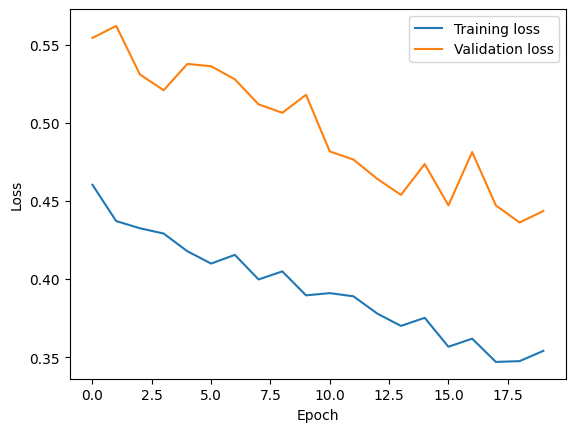

In [ ]:
# Вывод графиков результатов
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Оценка модели на тестовой выборке
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {(accuracy) * 100:.2f}%')

Test Loss: 0.4368, Test Accuracy: 79.08%


2 сеть

In [ ]:
import torch
import torch.nn as nn

class LeNet2(nn.Module):
    def __init__(self, num_classes):
        super(LeNet2, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.BatchNorm1d(120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Определение функции потерь и оптимизатора
model = LeNet2(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Обучение модели
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=40):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Валидация модели
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {(correct / total) * 100:.2f}%')

    return train_losses, val_losses

In [ ]:
# Обучение модели
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, test_loader)

Epoch [1/40], Train Loss: 0.5024, Val Loss: 0.5786, Val Accuracy: 67.85%
Epoch [2/40], Train Loss: 0.4462, Val Loss: 0.5323, Val Accuracy: 73.91%
Epoch [3/40], Train Loss: 0.4165, Val Loss: 0.5290, Val Accuracy: 72.55%
Epoch [4/40], Train Loss: 0.4065, Val Loss: 0.5049, Val Accuracy: 75.56%
Epoch [5/40], Train Loss: 0.3944, Val Loss: 0.4840, Val Accuracy: 76.59%
Epoch [6/40], Train Loss: 0.3974, Val Loss: 0.5202, Val Accuracy: 75.93%
Epoch [7/40], Train Loss: 0.3899, Val Loss: 0.5461, Val Accuracy: 71.71%
Epoch [8/40], Train Loss: 0.3904, Val Loss: 0.5012, Val Accuracy: 76.77%
Epoch [9/40], Train Loss: 0.3724, Val Loss: 0.4619, Val Accuracy: 77.69%
Epoch [10/40], Train Loss: 0.3809, Val Loss: 0.5196, Val Accuracy: 73.03%
Epoch [11/40], Train Loss: 0.3703, Val Loss: 0.5268, Val Accuracy: 74.31%
Epoch [12/40], Train Loss: 0.3664, Val Loss: 0.4739, Val Accuracy: 76.81%
Epoch [13/40], Train Loss: 0.3601, Val Loss: 0.5178, Val Accuracy: 75.19%
Epoch [14/40], Train Loss: 0.3701, Val Loss: 0.

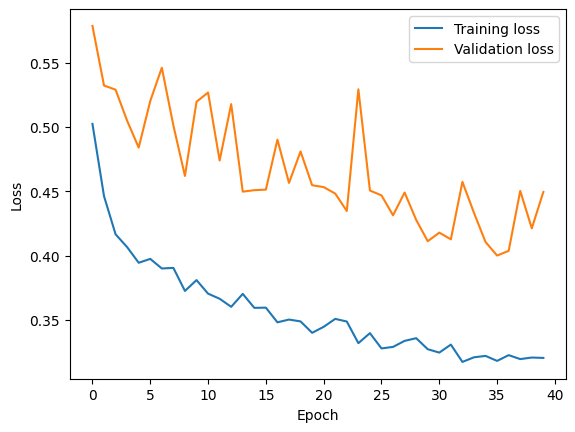

In [ ]:
# Вывод графиков результатов
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Оценка модели на тестовой выборке
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {(accuracy) * 100:.2f}%')

Test Loss: 0.4510, Test Accuracy: 78.09%


3 сеть

In [ ]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Определение функции потерь и оптимизатора
model = CustomCNN(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Обучение модели
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=30):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Валидация модели
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {(correct / total) * 100:.2f}%')

    return train_losses, val_losses

In [ ]:
# Обучение модели
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, test_loader)

Epoch [1/30], Train Loss: 0.4436, Val Loss: 0.5297, Val Accuracy: 74.64%
Epoch [2/30], Train Loss: 0.3795, Val Loss: 0.4317, Val Accuracy: 79.67%
Epoch [3/30], Train Loss: 0.3523, Val Loss: 0.4990, Val Accuracy: 76.77%
Epoch [4/30], Train Loss: 0.3401, Val Loss: 0.4698, Val Accuracy: 78.39%
Epoch [5/30], Train Loss: 0.3208, Val Loss: 0.4168, Val Accuracy: 80.62%
Epoch [6/30], Train Loss: 0.3200, Val Loss: 0.4266, Val Accuracy: 77.36%
Epoch [7/30], Train Loss: 0.2915, Val Loss: 0.4247, Val Accuracy: 80.11%
Epoch [8/30], Train Loss: 0.2962, Val Loss: 0.3565, Val Accuracy: 82.39%
Epoch [9/30], Train Loss: 0.2914, Val Loss: 0.4187, Val Accuracy: 80.44%
Epoch [10/30], Train Loss: 0.2839, Val Loss: 0.3577, Val Accuracy: 83.19%
Epoch [11/30], Train Loss: 0.2721, Val Loss: 0.3572, Val Accuracy: 84.07%
Epoch [12/30], Train Loss: 0.2701, Val Loss: 0.3536, Val Accuracy: 83.19%
Epoch [13/30], Train Loss: 0.2551, Val Loss: 0.3759, Val Accuracy: 82.75%
Epoch [14/30], Train Loss: 0.2524, Val Loss: 0.

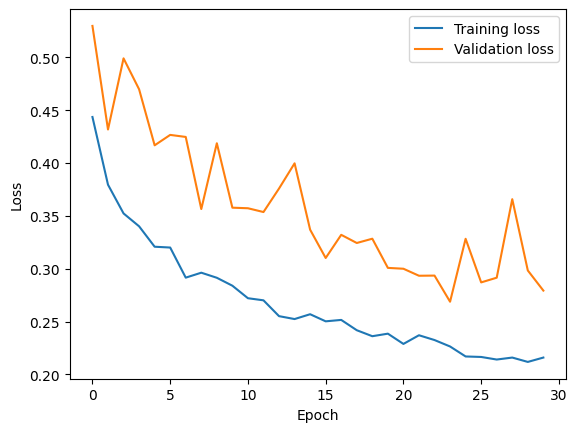

In [ ]:
# Вывод графиков результатов
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Оценка модели на тестовой выборке
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {(accuracy) * 100:.2f}%')

Test Loss: 0.2700, Test Accuracy: 86.97%


Таким образом, третья архитектура сети обучается быстрее, переобучения не возникает. На тестовых данных точность составила 86.97%.

#  Задание 2.

Порядок выполнения
1.  Загрузите датасет fmr.zip.
2.	Создайте 3 архитектуры сверточной нейронной сети для распознавания данных из набора fmr.zip. Обучите сеть и выведите результаты на тренировочной и валидационной выборках.
4.	Проверьте работу сети на тестовой выборке. Добейтесь точности не менее 85%.
5.	Загрузите файлы с картинками из интернета или создайте свои фотографии.
6.	Проверьте работу сети на собственных картинках.

In [ ]:
import zipfile
import os

# Путь к вашему архиву zip
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/middle_fmr.zip'

# Папка, куда будут распакованы файлы
extract_folder = '/content/middle_fmr'

# Распаковка архива
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Проверка содержимого папки
print(os.listdir(extract_folder))


['Mercedes', 'Ferrari', 'Renault']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
from torch.utils.data import random_split, Subset
import numpy as np

In [ ]:
# Загрузка датасета
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root='/content/middle_fmr', transform=transform)

In [ ]:
image_shape = dataset[0][0].shape  # Размерность изображений
num_classes = len(dataset.classes)  # Количество классов
classes_labels = dataset.classes  # Метки классов

print(image_shape, num_classes, classes_labels)

torch.Size([3, 64, 64]) 3 ['Ferrari', 'Mercedes', 'Renault']


In [ ]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

val_size = 0.15
test_size = 0.15
train_samples = int((1 - test_size) * len(dataset))
train_indices = list(range(train_samples))
test_samples = len(dataset) - train_samples

train_dataset, test_dataset = random_split(dataset, [train_samples, test_samples])

split_value = int(np.floor(val_size * train_samples))
np.random.shuffle(train_indices)

train_idx, val_idx = train_indices[split_value:], train_indices[:split_value]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# Вывод информации о количестве батчей
print(f"Количество батчей в обучающем DataLoader: {len(train_loader)}")
print(f"Количество батчей в проверочном DataLoader: {len(val_loader)}")
print(f"Количество батчей в тестовом DataLoader: {len(test_loader)}")

Количество батчей в обучающем DataLoader: 78
Количество батчей в проверочном DataLoader: 14
Количество батчей в тестовом DataLoader: 108


**1 архитектура**

In [ ]:
import torch
import torch.nn as nn

class SimpleCNN1(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN1, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.classifier(x)
        return x

In [ ]:
# Определение функции потерь и оптимизатора
model1 = SimpleCNN1(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
# Обучение модели
def train_model(model1, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Валидация модели
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {(correct / total) * 100:.2f}%')

    return train_losses, val_losses

In [ ]:
# Обучение модели
train_losses, val_losses = train_model(model1, criterion, optimizer, train_loader, test_loader)

Epoch [1/20], Train Loss: 0.6949, Val Loss: 0.9232, Val Accuracy: 53.28%
Epoch [2/20], Train Loss: 0.6139, Val Loss: 0.8710, Val Accuracy: 55.12%
Epoch [3/20], Train Loss: 0.5872, Val Loss: 0.8370, Val Accuracy: 63.06%
Epoch [4/20], Train Loss: 0.5501, Val Loss: 0.8033, Val Accuracy: 62.68%
Epoch [5/20], Train Loss: 0.5145, Val Loss: 0.7252, Val Accuracy: 67.73%
Epoch [6/20], Train Loss: 0.4591, Val Loss: 0.6627, Val Accuracy: 71.49%
Epoch [7/20], Train Loss: 0.3962, Val Loss: 0.7185, Val Accuracy: 70.64%
Epoch [8/20], Train Loss: 0.3313, Val Loss: 0.5013, Val Accuracy: 79.46%
Epoch [9/20], Train Loss: 0.2398, Val Loss: 0.4472, Val Accuracy: 84.59%
Epoch [10/20], Train Loss: 0.1523, Val Loss: 0.5554, Val Accuracy: 82.64%
Epoch [11/20], Train Loss: 0.0853, Val Loss: 0.3793, Val Accuracy: 89.64%
Epoch [12/20], Train Loss: 0.0381, Val Loss: 0.4849, Val Accuracy: 89.15%
Epoch [13/20], Train Loss: 0.0138, Val Loss: 0.5614, Val Accuracy: 89.85%
Epoch [14/20], Train Loss: 0.0070, Val Loss: 0.

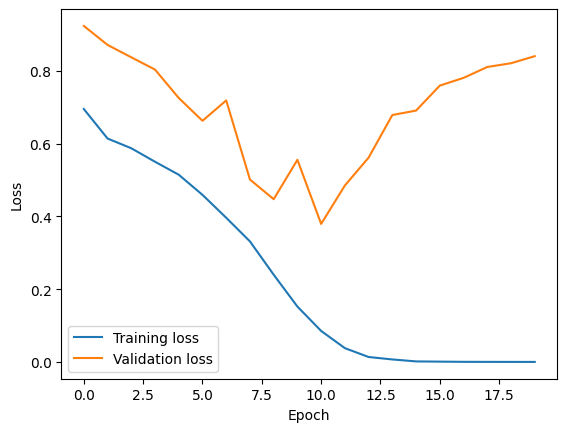

In [ ]:
# Вывод графиков результатов
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Оценка модели на тестовой выборке
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {(accuracy) * 100:.2f}%')

Test Loss: 0.8401, Test Accuracy: 89.03%


Модель склонна к переобучению

**3 сеть**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 6*3, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.BatchNorm2d(6*3),
            nn.Conv2d(6*3, 16*3, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),

                    )

        self.classifier = nn.Sequential(
                nn.Linear(1728, 192),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(192, 84),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(84, num_classes),
            )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Определение функции потерь и оптимизатора
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Обучение модели
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Валидация модели
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {(correct / total) * 100:.2f}%')

    return train_losses, val_losses

In [ ]:
# Обучение модели
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, test_loader)

Epoch [1/25], Train Loss: 0.7076, Val Loss: 0.9037, Val Accuracy: 52.55%
Epoch [2/25], Train Loss: 0.6290, Val Loss: 0.8860, Val Accuracy: 53.87%
Epoch [3/25], Train Loss: 0.6167, Val Loss: 0.9017, Val Accuracy: 53.78%
Epoch [4/25], Train Loss: 0.5954, Val Loss: 0.8196, Val Accuracy: 57.25%
Epoch [5/25], Train Loss: 0.5739, Val Loss: 0.8275, Val Accuracy: 55.33%
Epoch [6/25], Train Loss: 0.5484, Val Loss: 0.7456, Val Accuracy: 66.85%
Epoch [7/25], Train Loss: 0.5334, Val Loss: 0.7031, Val Accuracy: 69.74%
Epoch [8/25], Train Loss: 0.5242, Val Loss: 0.7337, Val Accuracy: 67.44%
Epoch [9/25], Train Loss: 0.5002, Val Loss: 0.6931, Val Accuracy: 66.62%
Epoch [10/25], Train Loss: 0.4752, Val Loss: 0.6397, Val Accuracy: 70.03%
Epoch [11/25], Train Loss: 0.4544, Val Loss: 0.6487, Val Accuracy: 70.24%
Epoch [12/25], Train Loss: 0.4311, Val Loss: 0.5962, Val Accuracy: 72.63%
Epoch [13/25], Train Loss: 0.4300, Val Loss: 0.6312, Val Accuracy: 73.30%
Epoch [14/25], Train Loss: 0.4182, Val Loss: 0.

In [ ]:
# Оценка модели на тестовой выборке
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {(accuracy) * 100:.2f}%')

Test Loss: 0.4183, Test Accuracy: 86.46%


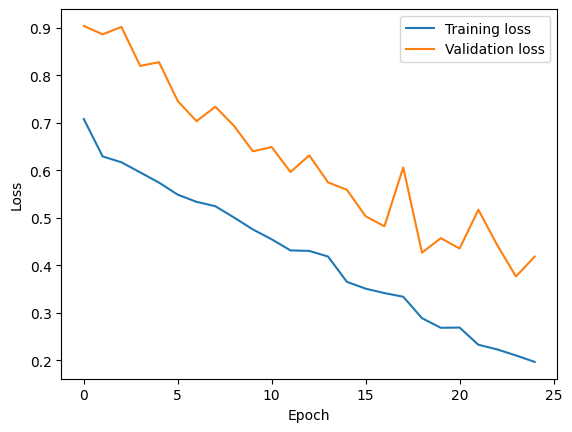

In [ ]:
# Вывод графиков результатов
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

СУПЕР! Добились 85% на тесте. Проверим работу сети на картинках.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Renault.jpeg to Renault.jpeg


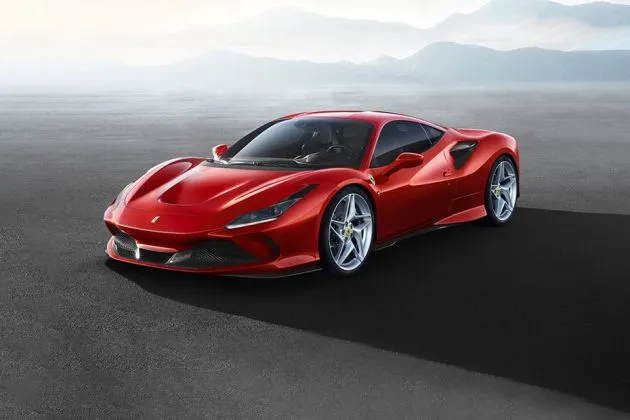

In [ ]:
from IPython.display import Image
Image('Ferrari.png')

In [ ]:
from PIL import Image
from torchvision import transforms

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0)
    return input_image

# Предсказание для 3 сети
image_path = 'Ferrari.png'
input_image = load_and_preprocess_image(image_path)
output = model(input_image)

# Преобразование выхода в вероятности и получение предсказанного класса
probabilities = nn.Softmax(dim=1)(output)
predicted_class = torch.argmax(probabilities, dim=1).item()
predicted_class_name = dataset.classes[predicted_class]

print(f'Predicted Class: {predicted_class, predicted_class_name}')

Predicted Class: (0, 'Ferrari')


ВЕРНО!

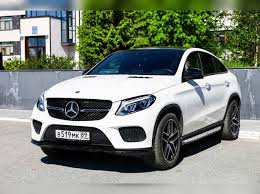

In [ ]:
from IPython.display import Image
Image('Mercedes.jpeg')

In [ ]:
from PIL import Image
from torchvision import transforms

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0)
    return input_image

# Предсказание для 3 сети
image_path = 'Mercedes.jpeg'
input_image = load_and_preprocess_image(image_path)
output = model(input_image)

# Преобразование выхода в вероятности и получение предсказанного класса
probabilities = nn.Softmax(dim=1)(output)
predicted_class = torch.argmax(probabilities, dim=1).item()
predicted_class_name = dataset.classes[predicted_class]

print(f'Predicted Class: {predicted_class, predicted_class_name}')

Predicted Class: (1, 'Mercedes')


ВЕРНО!

**3 сеть** (все что от нее осталось, обучение проводилось на 10 эпохах)

In [ ]:
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, 256, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout2d(p=0.3)
        )

        # Изменяем размерность выходных данных перед полносвязным слоем
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
                nn.Linear(256 * 6 * 6, 192),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(192, 84),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(84, num_classes),
            )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Определение функции потерь и оптимизатора
model2 = CustomCNN(in_channels=3, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving car.jpg to car (1).jpg


In [ ]:
from sklearn.metrics import accuracy_score

# Получение состояния модели best_model
best_model_state_dict = best_model.state_dict()

# Загрузка состояния модели в model
model.load_state_dict(best_model_state_dict)


# Установка модели в режим оценки
model.eval()

# Оценка модели на тестовой выборке
test_loss = 0.0
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Вычисление точности на тестовой выборке
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Loss: {test_loss / len(test_loader.dataset):.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.9330, Test Accuracy: 58.12%


In [ ]:
from PIL import Image
from torchvision import transforms

def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0)
    return input_image

# Предсказание для CNNModel5
image_path = 'car.jpg'
input_image = load_and_preprocess_image(image_path)
output = best_model(input_image)

# Преобразование выхода в вероятности и получение предсказанного класса
probabilities = nn.Softmax(dim=1)(output)
predicted_class = torch.argmax(probabilities, dim=1).item()
# Загрузка классов из обучающего набора данных до создания Subset
classes = train_dataset.dataset.classes

# Использование индексации по классам из classes
predicted_class_name = classes[predicted_class]


print(f'Predicted Class: {predicted_class, predicted_class_name}')

Predicted Class: (1, 'Mercedes')


ВЕРНО!

### Лучшая сеть №2: на тесте точность превысила 85%, модель не склонна к переобучению (как модель №1), а также ее точность довольно быстро растет  с увеличением эпох (в отличие от сети №3).